In [58]:
import tmps
from tmps.utils import fock, pauli, convert, state_reduction_as_array
import numpy as np
import mpnum as mp
from scipy.special import gamma
import matplotlib.pyplot as plt

## Set parameters

Number of bath sites:

In [59]:
N_bath = 30

Spin energy gap:

In [60]:
omega_0 = 1

Parameters for the ohmic spectral density:

In [61]:
alpha = 1
s = 1
omega_c = 1

Parameter for the initial state `|psi_0> = cos(theta) |1>  + sin(theta) |0>`

In [62]:
theta = np.pi/4

Local dimension of the bosonic bath

In [63]:
loc_dim = 10

Trotterization timestep:

In [64]:
tau = 0.01

Number of steps for the time evolution:

In [65]:
nof_steps = 100

Using second order Trotter decomposition:

In [66]:
second_order_trotter = False

Compression for the initial state, the state during the propagation and the operators

In [67]:
psi_0_compression = None
state_compression = {'method': 'svd', 'relerr': 1e-7}
op_compression = {'method': 'svd', 'relerr': 1e-10}

Local Hamiltonian of the System:

In [68]:
spin_loc = omega_0/2 * pauli.Z

Coupling between System and bath:

In [69]:
spin_coupl = pauli.Z

## Constructing initial state and operators

Initial state of the System:

In [70]:
ground = np.array([0.0, np.sin(theta)])
excited = np.array([np.cos(theta), 0.0])
sys_psi_0 = (ground + excited)

Initial state of the bath:

In [71]:
bath_psi_0 = tmps.utils.broadcast_number_ground_state(loc_dim, N_bath)

Initial state of the full chain:

In [72]:
psi_0 = mp.chain([convert.to_mparray(sys_psi_0, 'mps'), bath_psi_0])

Energies and couplings for the ohmic bath (see Chin et al., J. Math. Phys. 51, 092109 (2010)):

In [73]:
n = np.arange(N_bath)
c0 = np.sqrt(alpha*omega_c**2 * gamma(s+1))
omega = omega_c * (2*n + 1 + s)
t = omega_c * np.sqrt((n[:-1] + 1)*(n[:-1] + s + 1))

Local Hamiltonian of the bath:

In [74]:
fock_n = fock.n(loc_dim)
bath_loc = [energy * fock_n for energy in omega]

Bath coupling part of the Hamiltonian:

In [75]:
bath_coupling_op = np.kron(fock.a(loc_dim), fock.a_dag(loc_dim)) + \
                   np.kron(fock.a_dag(loc_dim), fock.a(loc_dim))
bath_bath_coupl = [coupling * bath_coupling_op for coupling in t]

Spin-Bath coupling operator:

In [76]:
spin_bath_coupl = c0 * (np.kron(spin_coupl, fock.a_dag(loc_dim)) + np.kron(spin_coupl.conj().T, fock.a(loc_dim)))

## Creating the propagator

In [77]:
%%time
propagator = tmps.chain.from_hamiltonian(psi_0, 'mps', [spin_loc] + bath_loc, [spin_bath_coupl] + bath_bath_coupl,
                                         tau=tau, state_compression_kwargs=state_compression,
                                         op_compression_kwargs=op_compression,
                                         second_order_trotter=second_order_trotter,
                                         psi_0_compression_kwargs=psi_0_compression)

Wall time: 4.35 s


## Initializing buffers to hold coherences and spin up populations of the spin

In [78]:
coherence = np.empty(nof_steps + 1)
population = np.empty(nof_steps + 1)
reduced_state = state_reduction_as_array(propagator.psi_t, 'mps', startsite=0, nof_sites=1)
coherence[0] = np.abs(reduced_state[0, 1])
population[0] = np.abs(reduced_state[0, 0])

## Propagation loop

In [79]:
%%time
for psi_t in propagator(nof_steps=nof_steps):
    print('Current ranks of the state: ', psi_t.ranks)
    reduced_state = state_reduction_as_array(psi_t, 'mps', startsite=0, nof_sites=1)
    coherence[propagator.step] = np.abs(reduced_state[0, 1])
    population[propagator.step] = np.abs(reduced_state[0, 0])

Current ranks of the state:  (2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2

Current ranks of the state:  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1)
Current ranks of the state:  (2, 2, 2, 2

## Plotting the results

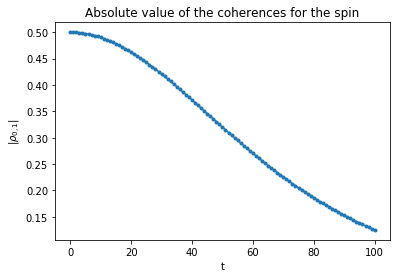

In [80]:
plt.plot(np.abs(coherence), '.-')
plt.title('Absolute value of the coherences for the spin')
plt.xlabel('t')
plt.ylabel('$\\left| \\rho_{0,1} \\right|$')
plt.show()

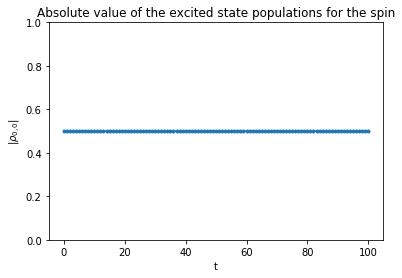

In [81]:
plt.plot(np.abs(population), '.-')
plt.title('Absolute value of the excited state populations for the spin')
plt.xlabel('t')
plt.ylabel('$\\left| \\rho_{0,0} \\right|$')
plt.ylim((0, 1))
plt.show()